# BEM114 Homework 2 - Statistical Arbitrage
**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**Student IDs:** 2176083, 2159859, 2157818

## Setup
Imports, Helper Functions, and DataFrames

In [23]:
'''
Imports
'''

import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [126]:
'''
Helper functions
'''

# Given a group of stocks, calculate equal-weighted and value-weighted weights
def calc_weights(group):
    # Calc equal weights
    group['weights_eq'] = 1 / float(group['decile'].count())
    # Calc total market equity of group
    group['TMV'] = group['MV'].sum()
    # Calc value weights
    group['weights_val'] = group['MV'] / group['TMV']
    return group

# Part b of problems 2,3,4: Calculates monthly returns from monthly weights
def part_b(df):
    # Calculate weights times returns
    df['weighted_val_ret'] = df['weights_val_lag'] * df['RET']
    df['weighted_eq_ret'] = df['weights_eq_lag'] * df['RET']

    # Sum up portfolio returns
    eqports = df.groupby(['date', 'decile_lag'])['weighted_eq_ret'].sum()
    eqports = eqports.unstack()
    
    # Drop if missing accounting data in early years
    eqports = eqports.dropna(axis=0)
    
    # Match data format of FF factors
    eqports = eqports * 100
    eqports = eqports.reset_index()

    valports = df.groupby(['date', 'decile_lag'])['weighted_val_ret'].sum()
    valports = valports.unstack()
    valports = valports.dropna(axis=0)
    valports = valports * 100
    valports = valports.reset_index()
    
    return eqports, valports

# Calculates returns and prints the returns mean, vol, and Sharpe ratio for a strategy
def analyze(df, strat_name, ret_col_name):
    df[ret_col_name] = df[1.0] - df[10.0]
    
    strat_mean = df[ret_col_name].mean()
    strat_vol = df[ret_col_name].std()
    strat_sharpe = strat_mean / strat_vol

    print(f"{strat_name} monthly returns have mean {strat_mean}, vol {strat_vol}, and Sharpe {strat_sharpe}")

# Estimates the CAPM and FF3 models on df_old using the returns found in ret_col_name
def estimate_capm_and_ff3(df_old, ret_col_name, ff3):
    # Merge in ff3 data. Keep separate from ff5 because there is a larger data range available in ff3.
    df = pd.merge(df_old, ff3, how='inner', on=['date'])
    assert(len(df) == len(df_old))
    
    # Estimate CAPM
    print('CAPM')
    print(sm.OLS(df[ret_col_name], sm.add_constant(df[['Mkt-RF']])).fit().summary())
    
    # Estimate FF3
    print('FF3')
    print(sm.OLS(df[ret_col_name], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])).fit().summary())

# Estimates the FF5 model on df_old using the returns found in ret_col_name, optionally adding momentum
def estimate_ff5(df_old, ret_col_name, ff5, add_momentum=False, mom_rets=None):
    # Merge in ff5 data. Truncates dates so create a df separate from ff3.
    df = pd.merge(df_old, ff5, how='inner', on=['date'])
    
    # Estimate FF5
    print('FF5')
    print(sm.OLS(df[ret_col_name], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit().summary())
    
    if add_momentum:
        # Estimate FF5 + Momentum
        print('FF5 + Momentum')
        df = pd.merge(df, mom_rets, how='inner', on=['date'])
        print(sm.OLS(df[ret_col_name], sm.add_constant(df_ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit().summary())

Equal-weighted portfolio
decile_lag     date        1.0        2.0        3.0        4.0        5.0  \
0           1926-07  -1.942698  -0.022857  -0.065936   0.555155   0.045432   
1           1926-08  -0.004996   0.006581   0.004258  -0.009743   0.032289   
2           1926-09  -0.841621  -3.933651  -0.311708  -0.116266  -2.308341   
3           1926-10   3.144084  -6.056331  -1.963123  -0.434619  -3.155964   
4           1926-11  -1.120561   2.194911   1.594653   8.971522   7.346117   
...             ...        ...        ...        ...        ...        ...   
1128        2020-08  -0.619165   2.102848   5.889660   8.218521   6.258390   
1129        2020-09  -0.904210  -0.645521  -2.273452  -2.721217  -4.598571   
1130        2020-10   1.009761  -1.518943  -0.948245   0.728229   1.683723   
1131        2020-11  27.767617  22.986844  23.661349  24.106834  22.072045   
1132        2020-12  14.936823  14.316497  12.369733   8.424371   9.636163   

decile_lag        6.0        7.0      

In [70]:
'''
Load CRSP data
'''

df = pd.read_csv('crsp_1926_2020.zip')

# Convert prices and returns to numeric and drop NaNs
df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df = df.dropna(subset=['PRC', 'RET'])

# Set types for relevant columns
df = df.astype({'date': 'string', 'SHRCD': 'int', 'EXCHCD': 'int'})

# Drop day information in the dates
df['date'] = df['date'].str[:-3]

In [71]:
'''
Load FF3 and FF5 data
'''

ff3 = pd.read_csv('ff3_factors.csv')
ff3 = ff3.astype({'date': 'string'})
ff3['date'] = ff3['date'].apply(lambda x: x[:4] + '-' + x[4:])

ff5 = pd.read_csv('ff5_factors.csv')
ff5 = ff5.astype({'date': 'string'})
ff5['date'] = ff5['date'].apply(lambda x: x[:4] + '-' + x[4:])

## Problem 1
### Part A

In [72]:
# Filter SHRCD and EXCHCD, set negative prices to NA
df = df[df['SHRCD'].isin([10, 11])]
df = df[df['EXCHCD'].isin([1, 2, 3])]
df.loc[df['PRC'] < 0, 'PRC'] = 'NA'
df

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT
2,10000,1986-02,10,3,NA,-0.257143,3680.0
3,10000,1986-03,10,3,NA,0.365385,3680.0
4,10000,1986-04,10,3,NA,-0.098592,3793.0
5,10000,1986-05,10,3,NA,-0.222656,3793.0
6,10000,1986-06,10,3,NA,-0.005025,3793.0
...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0


### Part B

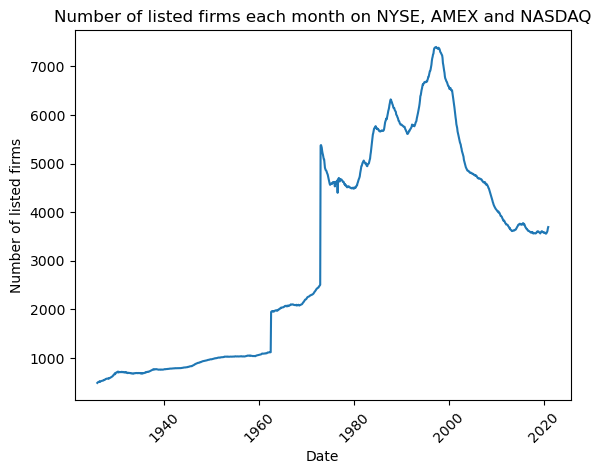

In [73]:
# Group by year and month
by_month = df.groupby(df['date'])['PERMNO'].nunique().reset_index()
by_month['date'] = pd.to_datetime(by_month['date'])

# Create plot of number of firms listed each month
plt.plot(by_month['date'], by_month['PERMNO'])
plt.title('Number of listed firms each month on NYSE, AMEX and NASDAQ')
plt.xlabel('Date')
plt.ylabel('Number of listed firms')
plt.xticks(rotation=45)
plt.show()

## Additional Setup
Merge FF3 data into df and clean up

In [108]:
# Merge ff3 data
df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')
df = df.dropna(subset='PRC')
df_merged = pd.merge(df, ff3, how='inner', on=['date'])

# Create MV column
df_merged['MV'] = df_merged['PRC'] * df_merged['SHROUT']

# Drop unnecessary columns
df_merged = df_merged.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT', 'SMB', 'HML', 'RF'], axis=1)
df_merged

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/2105386990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')


,PERMNO,date,RET,Mkt-RF,MV
0,10001,1986-09,-0.003077,-8.60,6317.625
1,10003,1986-09,-0.057692,-8.60,40149.375
2,10008,1986-09,-0.155963,-8.60,33867.500
3,10009,1986-09,-0.092157,-8.60,10315.500
4,10016,1986-09,-0.020000,-8.60,224959.000
...,...,...,...,...,...
2853548,84241,1984-12,0.000000,1.84,21850.000
2853549,85033,1984-12,0.000000,1.84,80750.000
2853550,85762,1984-12,0.093750,1.84,110687.500
2853551,89552,1984-12,-0.027778,1.84,45543.750


## Problem 2

### Part A

In [112]:
sortdf = df_merged.copy()
sortdf['rank'] = sortdf.groupby('date')['MV'].rank(pct=True)

# Label decile portfolios
sortdf['decile'] = np.ceil(sortdf['rank']*10)

# Calculate weights
# Introduces Nans because some rows do not have BM_decile
sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)

# Move weights and deciles forward one month
# We form portfolios at the end of this month, and then earn returns over
# the next month.
sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)

sortdf = sortdf.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
sortdf

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/740182562.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)


,PERMNO,date,RET,Mkt-RF,MV,decile_lag,weights_val_lag,weights_eq_lag
0,10001,1986-09,-0.003077,-8.60,6317.625,NaN,NaN,NaN
1,10003,1986-09,-0.057692,-8.60,40149.375,NaN,NaN,NaN
2,10008,1986-09,-0.155963,-8.60,33867.500,NaN,NaN,NaN
3,10009,1986-09,-0.092157,-8.60,10315.500,NaN,NaN,NaN
4,10016,1986-09,-0.020000,-8.60,224959.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2853548,84241,1984-12,0.000000,1.84,21850.000,2.0,0.003576,0.003268
2853549,85033,1984-12,0.000000,1.84,80750.000,5.0,0.003284,0.003268
2853550,85762,1984-12,0.093750,1.84,110687.500,8.0,0.002062,0.002525
2853551,89552,1984-12,-0.027778,1.84,45543.750,4.0,0.002916,0.003268


### Part B

In [120]:
eqports, valports = part_b(sortdf)

display(eqports.mean())
display(valports.mean())

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/405062773.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(eqports.mean())


decile_lag
1.0     3.064754
2.0     1.523890
3.0     1.338852
4.0     1.280415
5.0     1.273010
6.0     1.257685
7.0     1.165526
8.0     1.122161
9.0     1.085600
10.0    0.944707
dtype: float64

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/405062773.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(valports.mean())


decile_lag
1.0     2.474480
2.0     1.497221
3.0     1.339501
4.0     1.275793
5.0     1.270625
6.0     1.259370
7.0     1.165686
8.0     1.113407
9.0     1.081875
10.0    0.925801
dtype: float64

The mean monthly returns appear to be monotonic in both the equal-weighted and value-weighted portfolios.

### Part C

In [121]:
analyze(eqports, 'Equal-weighted Size', 'RET')
analyze(valports, 'Value-weighted Size', 'RET')

Equal-weighted Size monthly returns have mean 2.12004625937945, vol 15.024933210326825, and Sharpe 0.14110187577554856
Value-weighted Size monthly returns have mean 1.5486795076754531, vol 12.859333169533016, and Sharpe 0.12043233402993735


### Part D

In [123]:
print('Equal-Weighted Size:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eqports, 'RET', ff3)

print('\n\n\n\nValue-Weighted Size:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(valports, 'RET', ff3)

Equal-Weighted Size:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     223.9
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           2.49e-46
Time:                        01:34:58   Log-Likelihood:                -4574.9
No. Observations:                1133   AIC:                             9154.
Df Residuals:                    1131   BIC:                             9164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

For both the equal-weighted and value-weighted portfolios, the alphas for the CAPM model are greater than that of the FF3 model. In the equal-weighted portfolio, the alpha for the CAPM model is 1.43 while the alpha for the FF3 model is 0.89. In the value-weighted portfolio, the alpha for the CAPM model is 0.85 while the alpha for the FF3 model is 0.38.

### Part E

In [127]:
post_FF = eqports[eqports['date'] > '1992-00'].copy()
analyze(post_FF, 'Equal-weighted Size', 'RET')
estimate_capm_and_ff3(post_FF, 'RET', ff3)

Equal-weighted Size monthly returns have mean 1.5127794087585098, vol 7.678493027903491, and Sharpe 0.19701514389100824
CAPM
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.208
Date:                Fri, 19 Apr 2024   Prob (F-statistic):             0.0742
Time:                        01:38:49   Log-Likelihood:                -1201.1
No. Observations:                 348   AIC:                             2406.
Df Residuals:                     346   BIC:                             2414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [128]:
post_FF = eqports[eqports['date'] > '2002-00'].copy()
analyze(post_FF, 'Equal-weighted Size', 'RET')
estimate_capm_and_ff3(post_FF, 'RET', ff3)

Equal-weighted Size monthly returns have mean 1.2177608999822838, vol 6.098613681579861, and Sharpe 0.1996783143782965
CAPM
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     7.838
Date:                Fri, 19 Apr 2024   Prob (F-statistic):            0.00556
Time:                        01:39:08   Log-Likelihood:                -731.37
No. Observations:                 228   AIC:                             1467.
Df Residuals:                     226   BIC:                             1474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

Yes, size still works. As we can see from the results of the analysis, since the Fama French 1992 paper was published, the alpha is still high for a equal-weighted long-short small-minus-big portfolio in both the CAPM and FF3 models. The same can be said for after the Dot-Com Bubble burst (after 2002).

## Problem 3
### Part A

In [95]:
# Calculate cumulative returns from month t-11 to month t-1
temp = merged_df.copy()
cum_rets = temp.groupby('PERMNO')['RET'].shift(1).rolling(window=11).apply(lambda x: np.prod(1+x)-1)
cum_rets = cum_rets.rename('11M_RET')
cum_rets

2083662         NaN
666901          NaN
903523          NaN
1414458         NaN
1593760         NaN
             ...   
2622051    0.402388
28713      0.402953
2141970    0.758333
2497346    0.516154
598479     0.489742
Name: 11M_RET, Length: 400000, dtype: float64

In [98]:
# Merge 11 month rolling returns into df_merged
df_11m_rets = pd.merge(test, cum_rets, left_index=True, right_index=True)
assert(len(df_11m_rets) == len(test))
df_11m_rets = df_11m_rets.dropna()
df_11m_rets

,PERMNO,date,RET,Mkt-RF,MV,11M_RET
1621541,32459,1987-04,-0.015625,-2.11,58826.2500,-0.099840
1884223,18091,1950-07,0.246377,1.36,79894.0000,-0.024619
1949210,15579,1956-07,0.009346,4.84,40324.5000,0.335936
1664248,86020,1990-07,-0.125000,-1.90,8232.0000,0.396455
1678168,55256,1991-05,0.075630,3.65,225632.0000,0.407387
...,...,...,...,...,...,...
2622051,82615,1996-08,0.052632,2.77,39462.5000,0.402388
28713,81190,1987-03,0.137255,1.64,193720.0000,0.402953
2141970,44847,1967-12,0.106918,3.05,11374.0000,0.758333
2497346,28556,1981-08,-0.062500,-7.04,692910.0000,0.516154


In [99]:
# Add deciles
df_11m_rets['rank'] = df_11m_rets.groupby('date')['11M_RET'].rank(pct=True)
df_11m_rets['decile'] = np.ceil(df_11m_rets['rank']*10)

# Use calc_weights helper to get the equal- and value-weighted portfolios
df_weights = df_11m_rets.groupby(['date', 'decile']).apply(calc_weights)
df_weights['decile_lag'] = df_weights.groupby('PERMNO')['decile'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)

# Process final portfolio weights
df_weights = df_weights.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
df_weights

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/478063044.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_weights = df_11m_rets.groupby(['date', 'decile']).apply(calc_weights)


,PERMNO,date,RET,Mkt-RF,MV,11M_RET,decile_lag,weights_val_lag,weights_eq_lag
1621541,32459,1987-04,-0.015625,-2.11,58826.2500,-0.099840,NaN,NaN,NaN
1884223,18091,1950-07,0.246377,1.36,79894.0000,-0.024619,NaN,NaN,NaN
1949210,15579,1956-07,0.009346,4.84,40324.5000,0.335936,NaN,NaN,NaN
1664248,86020,1990-07,-0.125000,-1.90,8232.0000,0.396455,NaN,NaN,NaN
1678168,55256,1991-05,0.075630,3.65,225632.0000,0.407387,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2622051,82615,1996-08,0.052632,2.77,39462.5000,0.402388,6.0,0.000187,0.014085
28713,81190,1987-03,0.137255,1.64,193720.0000,0.402953,7.0,0.000541,0.028571
2141970,44847,1967-12,0.106918,3.05,11374.0000,0.758333,NaN,NaN,NaN
2497346,28556,1981-08,-0.062500,-7.04,692910.0000,0.516154,9.0,0.126587,0.047619


### Part B

In [100]:
eq_decile_returns, val_decile_returns = part_b(df_weights)

display(eq_decile_returns.mean())
display(val_decile_returns.mean())

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/212339553.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(eq_decile_returns.mean())


decile_lag
1.0     1.394087
2.0     1.181323
3.0     1.170808
4.0     1.414150
5.0     1.078388
6.0     1.396519
7.0     1.464200
8.0     1.306870
9.0     1.303382
10.0    1.250091
dtype: float64

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/212339553.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(val_decile_returns.mean())


decile_lag
1.0     1.671281
2.0     1.052046
3.0     0.938447
4.0     1.389365
5.0     1.177785
6.0     1.245587
7.0     1.501150
8.0     1.484849
9.0     1.142794
10.0    1.348813
dtype: float64

### Part C

In [103]:
analyze(eq_decile_returns, 'Equal-weighted Momentum', 'MOM')
analyze(val_decile_returns, 'Value-weighted Momentum', 'MOM')

Equal-weighted Momentum has mean 0.14399673193612536, vol 6.596432291696401, and Sharpe 0.0218294868450918
Value-weighted Momentum has mean 0.322467881828225, vol 9.055360076898545, and Sharpe 0.03561071885488954


### Part D

In [106]:
print('Equal-Weighted Momentum:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eq_decile_returns, 'MOM', ff3)
estimate_ff5(eq_decile_returns, 'MOM', ff5)

print('\n\n\n\nValue-Weighted Momentum:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(val_decile_returns, 'MOM', ff3)
estimate_ff5(val_decile_returns, 'MOM', ff5)

Equal-Weighted Momentum:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                    MOM   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.140
Date:                Fri, 19 Apr 2024   Prob (F-statistic):            0.00765
Time:                        01:06:09   Log-Likelihood:                -3648.5
No. Observations:                1105   AIC:                             7301.
Df Residuals:                    1103   BIC:                             7311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

The value-weighted momentum portfolios have far better alphas. Perhaps moving the market is a larger factor for the momentum strategy than the other strategies.

Under the CAPM model, the FF3 model, and the FF5 model, the alpha that the equal-weighted and value-weighted momentum strategies are generating is not statistically significant. However, the alpha is consistently smaller under the FF5 model, indicating that FF5 does a decent job pricing momentum.

### Part E
We find it likely that the positive momentum alphas are indicative of some unpriced risk. For one, since the momentum papers have been out for a while and this strategy is relatively easy to implement, it stands to reason that the market has priced momentum into the equation already.

Second, it is not hard to imagine that a momentum strategy could face extreme risk: if the portfolio is rebalanced monthly and happens to buy into hot stocks at the start of the month, there is no guarantee that this momentum will carry through the whole month, as just one example.

## Problem 4
### Part A
Notes: Losing ~3000 (<0.1% of) rows since FF website starts July 1926, Professor Sinclair's data starts January 1926. We also assume that once data starts for a given stock, then it continues to be present every month until it stops.

In [31]:
# Merge ff3 data
df_merged = pd.merge(df, ff3, how='inner', on=['date'])

# Create MV column
df_merged['MV'] = df_merged['PRC'] * df_merged['SHROUT']

# Drop unnecessary columns
df_merged = df_merged.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT', 'SMB', 'HML', 'RF'], axis=1)
df_merged

,PERMNO,date,RET,Mkt-RF,Ret-RF,MV
11,10015,1986-02,0.086420,7.13,-0.443580,4.386800e+04
12,10016,1986-02,0.394545,7.13,-0.135455,2.455650e+05
13,10017,1986-02,0.065089,7.13,-0.464911,2.580300e+05
20,10057,1986-02,-0.100917,7.13,-0.630917,7.691775e+04
22,10074,1986-02,0.207547,7.13,-0.322453,1.401600e+04
...,...,...,...,...,...,...
3560037,93422,2020-12,0.484472,4.63,0.474472,5.806170e+05
3560038,93423,2020-12,0.109665,4.63,0.099665,2.897716e+06
3560039,93426,2020-12,0.076239,4.63,0.066239,3.951370e+05
3560040,93434,2020-12,0.122605,4.63,0.112605,1.001035e+05


In [32]:
# Applies the rolling ols and returns the betas where there are enough months
# or np.NaN where there are not enough months
def rolling_ols(group):
    dates = np.array(group['date'])
    
    if len(group) >= 36:
        y = group['Ret-RF']
        x = sm.add_constant(group['Mkt-RF'])
        model = RollingOLS(y, x, window=36)
        
        beta_vals = np.array(model.fit().params[['Mkt-RF']].values)
        return np.column_stack((dates, beta_vals))
    else:
        return np.column_stack((dates, np.full(len(group), np.nan)))

# Get the market beta for stock i from time t-36 to time t
beta_i_t = df_merged.groupby('PERMNO').apply(rolling_ols)
beta_i_t = pd.DataFrame(beta_i_t, columns=['beta'])
beta_i_t = beta_i_t.explode('beta')
beta_i_t[['date', 'beta']] = beta_i_t['beta'].apply(lambda el: pd.Series(el))
beta_i_t

,beta,date
PERMNO,,
10001,NaN,1986-09
10001,NaN,1986-10
10001,NaN,1986-11
10001,NaN,1986-12
10001,NaN,1987-01
...,...,...
93436,0.021938,2020-08
93436,0.022043,2020-09
93436,0.022111,2020-10


In [33]:
# Merge betas into df and drop NaN betas
df_betas = pd.merge(df_merged, beta_i_t, how='inner', on=['PERMNO', 'date'])
assert(len(df_betas) == len(df_merged))
df_betas = df_betas.dropna()
df_betas

,PERMNO,date,RET,Mkt-RF,Ret-RF,MV,beta
147862,10016,1989-01,0.054054,6.10,-0.495946,4.220580e+05,0.015143
147878,10057,1989-01,0.063158,6.10,-0.486842,6.280000e+04,0.013598
147911,10137,1989-01,-0.003344,6.10,-0.553344,1.935734e+06,0.005231
147916,10145,1989-01,0.069231,6.10,-0.480769,5.168924e+06,0.011563
147920,10154,1989-01,0.032258,6.10,-0.517742,2.797600e+04,0.012759
...,...,...,...,...,...,...,...
2853548,93422,2020-12,0.484472,4.63,0.474472,5.806170e+05,0.056771
2853549,93423,2020-12,0.109665,4.63,0.099665,2.897716e+06,0.029131
2853550,93426,2020-12,0.076239,4.63,0.066239,3.951370e+05,0.018964
2853551,93434,2020-12,0.122605,4.63,0.112605,1.001035e+05,0.012075


In [34]:
# Add deciles
df_betas['rank'] = df_betas.groupby('date')['beta'].rank(pct=True)
df_betas['decile'] = np.ceil(df_betas['rank']*10)

# Use calc_weights helper to get the equal- and value-weighted portfolios
df_weights = df_betas.groupby(['date', 'decile']).apply(calc_weights)
df_weights['decile_lag'] = df_weights.groupby('PERMNO')['decile'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)

# Process final portfolio weights
df_weights = df_weights.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
df_weights

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/2288995967.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_weights = df_betas.groupby(['date', 'decile']).apply(calc_weights)


,PERMNO,date,RET,Mkt-RF,Ret-RF,MV,beta,decile_lag,weights_val_lag,weights_eq_lag
147862,10016,1989-01,0.054054,6.10,-0.495946,4.220580e+05,0.015143,NaN,NaN,NaN
147878,10057,1989-01,0.063158,6.10,-0.486842,6.280000e+04,0.013598,NaN,NaN,NaN
147911,10137,1989-01,-0.003344,6.10,-0.553344,1.935734e+06,0.005231,NaN,NaN,NaN
147916,10145,1989-01,0.069231,6.10,-0.480769,5.168924e+06,0.011563,NaN,NaN,NaN
147920,10154,1989-01,0.032258,6.10,-0.517742,2.797600e+04,0.012759,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2853548,93422,2020-12,0.484472,4.63,0.474472,5.806170e+05,0.056771,10.0,0.000783,0.003367
2853549,93423,2020-12,0.109665,4.63,0.099665,2.897716e+06,0.029131,10.0,0.005246,0.003367
2853550,93426,2020-12,0.076239,4.63,0.066239,3.951370e+05,0.018964,7.0,0.000179,0.003378
2853551,93434,2020-12,0.122605,4.63,0.112605,1.001035e+05,0.012075,3.0,0.000015,0.003378


### Part B

In [35]:
eq_decile_returns, val_decile_returns = part_b(df_weights)

display(eq_decile_returns.mean())
display(val_decile_returns.mean())

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/212339553.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(eq_decile_returns.mean())


decile_lag
1.0     1.252606
2.0     1.198483
3.0     1.305394
4.0     1.429075
5.0     1.456718
6.0     1.519954
7.0     1.574645
8.0     1.593983
9.0     1.534555
10.0    1.659970
dtype: float64

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_44693/212339553.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(val_decile_returns.mean())


decile_lag
1.0     0.812200
2.0     0.890508
3.0     1.032927
4.0     1.029400
5.0     1.125500
6.0     1.034687
7.0     1.096523
8.0     1.160797
9.0     1.164721
10.0    1.197742
dtype: float64

Neither the mean equal-weighted BAB portfolio returns nor the mean value-weighted BAB portfolio returns are monotonic, though there is a strong general upward trend as the beta decile increases. This makes sense, as the market has gone up on average from 1926, stocks with higher beta would have higher returns on average.

### Part C

In [36]:
analyze(eq_decile_returns, 'Equal-weighted BAB', 'BAB')
analyze(val_decile_returns, 'Value-weighted BAB', 'BAB')

Equal-weighted BAB has mean -0.40736301018025595, vol 8.455873244789354, and Sharpe -0.048175155703910254
Value-weighted BAB has mean -0.38554245363517525, vol 8.396169730966003, and Sharpe -0.04591884942645359


### Part D

In [39]:
print('Equal-Weighted Betting-Against-Beta:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eq_decile_returns, ff3)
estimate_ff5(eq_decile_returns, 'BAB', ff5, add_momentum=True, mom_rets=None)

print('\n\n\n\nValue-Weighted Betting-Against-Beta:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(val_decile_returns, ff3)
estimate_ff5(val_decile_returns, 'BAB', ff5, add_momentum=True, mom_rets=None)

Equal-Weighted Betting-Against-Beta:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                    BAB   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1078.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):          3.12e-165
Time:                        00:22:24   Log-Likelihood:                -3525.5
No. Observations:                1098   AIC:                             7055.
Df Residuals:                    1096   BIC:                             7065.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

### Part E
We are taking a long position in low-beta stocks and a short position in high-beta stocks. Therefore, on average, if the market goes up and the high beta stocks perform comparatively better, we will lose money.

Consider reducing the correlation of the assets with each other (not just to the market)